# AUTO-PLATE-RECOGNITION
#### UCLA CS145 - Professor Si Si
#### TEAM NAME: Deep Learners
----
#### TEAM MEMBERS:
Caleb Lee   UID: 305-330-193    Email: bkcaleb45@g.ucla.edu 

Dylan Phe	UID: 505-834-475	Email: dylanphe@g.ucla.edu

Kevin Wang	UID:  305-503-382      Email: kwang1083@g.ucla.edu

---

## I. Importing the necessary packages

In [27]:
import os
import random
import csv
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

## II. Preparing and Pre-Procesing the Dataset

### 2.(a). Loading and Visualizing the dataset 

The dataset consists of 2,951 images of license plates from all 51 U.S. states, which was obtained from the following source: https://www.kaggle.com/code/tolgadincer/us-license-plates-data-quick-overview/input?select=data. We then organized this data into a table format of dimensions 2,951x2(file_list.csv). Each entry in the table contains two attributes, namely "Label" and "Image", which serve to identify each image file along with its corresponding label. In addition, we also split them into the training dataset(train_data.csv) and the testing dataset(test_data.csv). The process to achieve this is as follows:

In [28]:
# Directory path
dataset_path = 'dataset'

# CSV file path
csv_file = 'file_list.csv'
test_data_file = 'test_data.csv'
train_data_file = 'train_data.csv'

# Function to get the file list in a directory
def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

# Check if the CSV files already exist
csv_file_exists = os.path.exists(csv_file)
test_data_file_exists = os.path.exists(test_data_file)
train_data_file_exists = os.path.exists(train_data_file)

# Generate CSV file if it doesn't exist
if not csv_file_exists:
    # Get directory list in /dataset
    directories = [directory for directory in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, directory))]

    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Iterate through directories
        for directory in directories:
            # Get file list in the current directory
            file_list = get_file_list(os.path.join(dataset_path, directory))

            # Write file list to CSV
            for file_name in file_list:
                writer.writerow([directory, file_name])

    print("CSV file generated successfully.")
else:
    print("CSV file already exists. Skipping generation.")

# Read the data from the original CSV file if it exists
data = []
if csv_file_exists:
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row)

    # Shuffle the data randomly
    random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * 9 / 10)

    # Split the data into test and train sets
    train_data = data[:split_index+1]
    test_data = data[split_index:]

    # Write test data to CSV if it doesn't exist
    if not test_data_file_exists:
        with open(test_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(test_data)
        print("Test data CSV file generated successfully.")
    else:
        print("Test data CSV file already exists. Skipping generation.")

    # Write train data to CSV if it doesn't exist
    if not train_data_file_exists:
        with open(train_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(train_data)
        print("Train data CSV file generated successfully.")
    else:
        print("Train data CSV file already exists. Skipping generation.")

    print("Data separation completed successfully.")


CSV file already exists. Skipping generation.
Test data CSV file already exists. Skipping generation.
Train data CSV file already exists. Skipping generation.
Data separation completed successfully.


After the csv files were created, we utilized pandas to read both the train_data.csv and the test_data.csv and converted them into train and test dataframes as shown below. The training dataframe should contain 3873 rows whereas the testing dataset should contain 388 rows. The proportion of the split is 9:1.

In [4]:
train = pd.read_csv('/content/drive/MyDrive/auto-plate-detector/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/auto-plate-detector/test_data.csv')
print(f"Training data = {train.shape}")
print(f"Testing data = {test.shape}")
train

Mounted at /content/drive
Training data = (2951, 2)
Testing data = (328, 2)


,Label,Image
0,Missouri,c2279f4a173509.jpg
1,SouthDakota,e0a2bee82c7b29.jpg
2,Pennsylvania,4dc2772e7e3ddd.jpg
3,Massachusetts,21685515aa4999.png
4,Delaware,ae03d6f2677fa4.jpg
...,...,...
2946,Michigan,21680287dfe37d.png
2947,Florida,21572733ecdb1b.png
2948,Washington,4ed9656a5fd7b4.jpg
2949,Virginia,b1b47d79cd01b9.jpg


Given the tables above, we can easily obtain the image files and its corresponding true labels from the dataframes while also being able to distinguish between the two for the purposes of trainings and making predictions. The code below is written and executed as a mean to visualize our dataset.

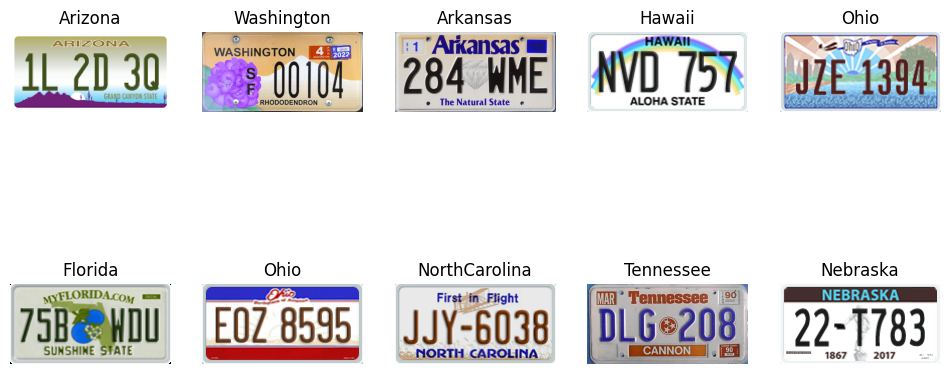

In [29]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = os.path.join('dataset', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
    img = cv2.imread(path)
    ax[i].imshow(img)
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
plt.show()

In order to enhance the visibility of the State's name letters against the background in our image dataset, we employ several pre-processing steps. 
1. Increase the image intensity via convertScaleAbs() by applying an alpha value of 1 and a beta value of 2. This adjustment helps to amplify the overall brightness of the image. 
2. Convert the images to grayscale, simplifying the color information and focusing solely on the grayscale intensity values. 
3. To further improve the contrast and reduce noise, we utilize histogram equalization and anisotropic diffusion. Histogram equalization redistributes the intensity values in the image, enhancing the overall contrast and making the letters more distinguishable. Anisotropic diffusion, on the other hand, smooths the image while preserving important edges and details, effectively denoising the image and refining the letter shapes. 
4. Since the State's names typically appear at the top or bottom of the license plate, we split the images into these specific regions. By isolating these regions, we can concentrate our processing on the areas where the State's names are commonly located. 
5. Enhance the image one final time to ensure optimal visibility of the letters by inverting between the white and the dark part of the images if they reached a certain threshold
6. Normalized the images.
7. Employ Otsu's algorithm to binarize the image. This algorithm automatically determines the optimal threshold value to separate the image into black and white pixels, effectively isolating the letters from the background.

By following these pre-processing steps, we ensure that the State's name letters are distinguishable from the background, thus facilitating subsequent analysis and recognition tasks.

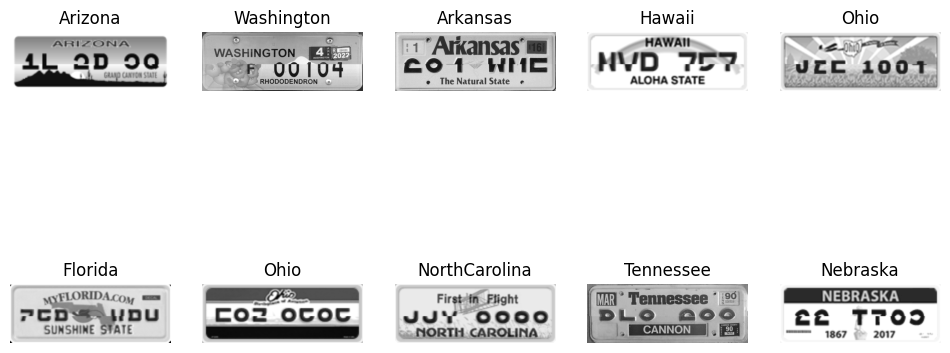

In [30]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = os.path.join('dataset', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 500))
    
    img = cv2.convertScaleAbs(img, alpha=1, beta=2)
    
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the height of the image
    height = img.shape[0]
    
    # Cut the image in half
    top_img = gray_img[0:int((height/2.5)), :]
    bottom_img = gray_img[int(2*(height/3)):height, :]
    
    concat_img = np.concatenate((top_img, bottom_img), axis=0)
    
    # Calculate the average brightness of the image
    average_brightness = np.mean(concat_img)
    
    # Define threshold values for brightness adjustment
    dark_threshold =   60# Adjust this value to determine what is considered dark
    
    if average_brightness < dark_threshold:
        # Invert the dark and light parts of the image
        concat_img = cv2.bitwise_not(concat_img)
        
    # Increase the contrast between letters and background
    #concat_img = cv2.bitwise_not(concat_img)
    enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    ax[i].imshow(enhanced_img, cmap='gray')
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
    #ax[i].imshow(binary_img, cmap='gray')
    #ax[i].set_title(train.loc[idx, 'Label'])
    #ax[i].axis('off')

plt.show()

### 2.(b) Pre-Processing and Spliting the dataset into the training, validation, and test datasets

To prepare our dataset for the training and the prediction stages, we parse the images and append them to their corresponding row within dataframes. However, since there are many data to process and some pcs might not have sufficient memory, we instead split them into eight splits and process them one by one. 

In [13]:
def split_data(data, parts):
    # Split the data into the specified number of parts
    splits = np.array_split(data, parts)

    images = []
    labels = []

    # Loop through the splits
    for split in splits:
        # Parse the images in this split
        split_images, split_labels = parse_images(split)

        # Append the parsed images and labels to the lists
        images.append(split_images)
        labels.append(split_labels)

    # Concatenate the splits to get the final datasets
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

def parse_images(data):
    images = []
    labels = []

    # Loop through the CSV entries and load each image
    for index, row in data.iterrows():
        img_path =  '/content/drive/MyDrive/auto-plate-detector/dataset/' + row['Label'] + '/' + row['Image']
        img = cv2.imread(img_path)

        # Resize the image to 500x1000 (looking at img.shape, this is around the average image size)
        img = cv2.resize(img, (1000, 500))
        
        img = cv2.convertScaleAbs(img, alpha=1, beta=2)
        
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate the height of the image
        height = img.shape[0]
        
        # Cut the image in half
        top_img = gray_img[0:int((height/2.5)), :]
        bottom_img = gray_img[int(2*(height/3)):height, :]
        
        concat_img = np.concatenate((top_img, bottom_img), axis=0)
        
        # Calculate the average brightness of the image
        average_brightness = np.mean(concat_img)
        
        # Define threshold values for brightness adjustment
        dark_threshold =   60# Adjust this value to determine what is considered dark
        
        if average_brightness < dark_threshold:
            # Invert the dark and light parts of the image
            concat_img = cv2.bitwise_not(concat_img)
            
        # Increase the contrast between letters and background
        #concat_img = cv2.bitwise_not(concat_img)
        enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        images.append(enhanced_img)
        labels.append(row['Label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



# Split the data into eighths and parse the images
train_valid_X, train_valid_Y = split_data(train, 8)
test_X, test_Y = split_data(test, 8)

#np.save('train_X.npy', train_X)
#np.save('train_Y.npy', train_Y)
#np.save('test_X.npy', test_X)
#np.save('test_Y.npy', test_Y)

In order to give an estimate of each model prediction performance while fine tuning their hyperparameters, we will also withold a sample of the training dataset back from being used to train the model to which we will refer to as the validation dataset. The final shapes of all the three dataframes are shown below.

In [14]:
#train_X = np.load('train_X.npy')
#train_Y = np.load('train_Y.npy')
#test_X = np.load('test_X.npy')
#test_Y = np.load('test_Y.npy')

print("Shape of train X before validation set: ", np.shape(train_valid_X))
print("Shape of train Y before validation set: ", np.shape(train_valid_Y))

#Use 20% of training data for validation
ind_valid = np.random.choice(2951, 500, replace=False)
ind_train = np.array(list(set(range(2951)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(train_X, valid_X) = train_valid_X[ind_train], train_valid_X[ind_valid] 
(train_Y, valid_Y) = train_valid_Y[ind_train], train_valid_Y[ind_valid]

encoder = LabelEncoder()

#encode string labels into integers for SparseCategoricalCrossentropy Loss
train_Y = encoder.fit_transform(train_Y)
valid_Y = encoder.transform(valid_Y)
test_Y = encoder.transform(test_Y)

print("Shape of final train X: ", train_X.shape)
print("Shape of final train y: ", train_Y.shape)

print("Shape of final validation X: ", valid_X.shape)
print("Shape of final valid y: ", valid_Y.shape)
print("Shape of test X: ", np.shape(test_X))
print("Shape of test Y: ", np.shape(test_Y))


Shape of train X before validation set:  (2951, 367, 1000)
Shape of train Y before validation set:  (2951,)
Shape of final train X:  (2451, 367, 1000)
Shape of final train y:  (2451,)
Shape of final validation X:  (500, 367, 1000)
Shape of final valid y:  (500,)
Shape of test X:  (328, 367, 1000)
Shape of test Y:  (328,)


### III.(a) Training Model 1 (5 convolutional blocks with fully connected last layer)

In [15]:
# Building the CNN model using sequential class
cnn_model_1 = Sequential()

# Conv. block 1
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(367, 1000, 1)))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 2
cnn_model_1.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 3
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 4
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 5
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_model_1.add(Flatten()) # Flattens the input
cnn_model_1.add(Dense(51, activation='softmax')) # Output FC layer with softmax activation (51 classes)


# Printing the model summary
cnn_model_1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 367, 1000, 25)     275       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 123, 1000, 25)    0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 123, 1000, 25)    100       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 123, 1000, 25)     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 123, 1000, 50)     12550     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 41, 1000, 50)    

In [16]:
# Model parameters
learning_rate = 1e-3
epochs = 10
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model_1.compile(loss='sparse_categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_1_results = cnn_model_1.fit(train_X,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
817/817 [==============================] - 73s 87ms/step - loss: 3.8767 - accuracy: 0.4308 - val_loss: 2.1094 - val_accuracy: 0.6700
Epoch 2/10
817/817 [==============================] - 71s 87ms/step - loss: 1.3118 - accuracy: 0.7462 - val_loss: 1.2560 - val_accuracy: 0.7820
Epoch 3/10
817/817 [==============================] - 70s 86ms/step - loss: 0.5045 - accuracy: 0.8723 - val_loss: 1.1781 - val_accuracy: 0.7940
Epoch 4/10
817/817 [==============================] - 71s 87ms/step - loss: 0.2668 - accuracy: 0.9229 - val_loss: 1.1778 - val_accuracy: 0.8260
Epoch 5/10
817/817 [==============================] - 70s 86ms/step - loss: 0.1893 - accuracy: 0.9486 - val_loss: 1.2071 - val_accuracy: 0.8360
Epoch 6/10
817/817 [==============================] - 70s 86ms/step - loss: 0.1609 - accuracy: 0.9535 - val_loss: 1.3151 - val_accuracy: 0.8340
Epoch 7/10
817/817 [==============================] - 71s 87ms/step - loss: 0.1318 - accuracy: 0.9608 - val_loss: 1.3735 - val_accuracy:

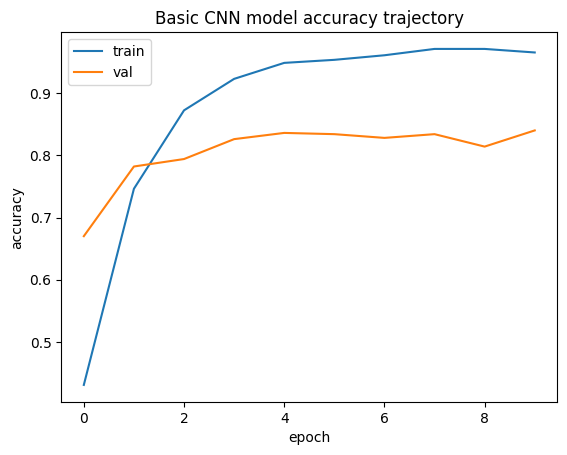

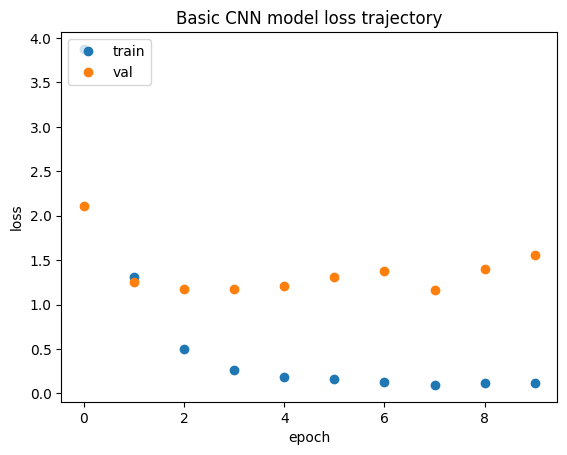

In [17]:
# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
## Testing the basic CNN model

cnn_score = cnn_model_1.evaluate(test_X, test_Y, verbose=0)
print('Test accuracy of the first CNN model:', cnn_score[1])

Test accuracy of the first CNN model: 0.7804877758026123


### III.(b) Training Model 2 ()

### (iii)(c) Training Model 3 ()

### (iv) Model Comparison and Visualization